<h1 style="text-align:center;"><b>Laboratorio 9</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

https://github.com/ArielaMishaanCohen/17-Lab-9-SparkML.git

In [35]:
import os

os.environ["PYSPARK_PYTHON"] = r"C:\Users\Alina Tatjana\AppData\Local\Programs\Python\Python310\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\Alina Tatjana\AppData\Local\Programs\Python\Python310\python.exe"

# Librerías

In [36]:
import pandas as pd
import pyspark 
from pyspark import SparkContext
from pyspark.ml.feature import VectorAssembler, PCA, StandardScaler
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [37]:
spark = SparkSession.builder.appName("Lab 9").getOrCreate()

# Análisis Exploratorio Avanzado y Segmentación

## Preparación

In [38]:
df_fallecidos = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('ine/fallecidos_junto.csv')
df_hechos = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('ine/hechos_junto.csv')
df_vehiculos = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('ine/vehiculos_junto.csv')

### Fallecidos

In [39]:
df_fallecidos.schema

StructType([StructField('núm_corre0', DoubleType(), True), StructField('año_ocu', IntegerType(), True), StructField('mes_ocu', StringType(), True), StructField('día_ocu', IntegerType(), True), StructField('día_sem_ocu', IntegerType(), True), StructField('hora_ocu', IntegerType(), True), StructField('g_hora', IntegerType(), True), StructField('g_hora_5', IntegerType(), True), StructField('depto_ocu', IntegerType(), True), StructField('mupio_ocu', StringType(), True), StructField('área_geo_ocu', DoubleType(), True), StructField('zona_ocu', IntegerType(), True), StructField('sexo_per', IntegerType(), True), StructField('edad_per', IntegerType(), True), StructField('mayor_menor', IntegerType(), True), StructField('g_edad_80ymás', StringType(), True), StructField('g_edad_60ymás', IntegerType(), True), StructField('edad_quinquenales', StringType(), True), StructField('fall_les', IntegerType(), True), StructField('int_o_noint', IntegerType(), True), StructField('tipo_veh', IntegerType(), True

In [40]:
df_fallecidos.show(10)

+----------+-------+-------+-------+-----------+--------+------+--------+---------+---------+------------+--------+--------+--------+-----------+-------------+-------------+-----------------+--------+-----------+--------+---------+---------+----------+------------+--------+-----------+-----------+---------+
|núm_corre0|año_ocu|mes_ocu|día_ocu|día_sem_ocu|hora_ocu|g_hora|g_hora_5|depto_ocu|mupio_ocu|área_geo_ocu|zona_ocu|sexo_per|edad_per|mayor_menor|g_edad_80ymás|g_edad_60ymás|edad_quinquenales|fall_les|int_o_noint|tipo_veh|marca_veh|color_veh|modelo_veh|g_modelo_veh|tipo_eve|Núm_corre26|zona_ciudad|num_corre|
+----------+-------+-------+-------+-----------+--------+------+--------+---------+---------+------------+--------+--------+--------+-----------+-------------+-------------+-----------------+--------+-----------+--------+---------+---------+----------+------------+--------+-----------+-----------+---------+
|       1.0|   2015|      1|      1|          4|      16|     3|       2|

In [41]:
df_fallecidos.count()

91367

### Hechos

In [42]:
df_hechos.schema

StructType([StructField('núm_corre', DoubleType(), True), StructField('año_ocu', IntegerType(), True), StructField('mes_ocu', StringType(), True), StructField('día_ocu', IntegerType(), True), StructField('hora_ocu', StringType(), True), StructField('día_sem_ocu', StringType(), True), StructField('g_hora', StringType(), True), StructField('g_hora_5', StringType(), True), StructField('depto_ocu', StringType(), True), StructField('mupio_ocu', StringType(), True), StructField('área_geo_ocu', DoubleType(), True), StructField('zona_ocu', StringType(), True), StructField('tipo_veh', StringType(), True), StructField('marca_veh', StringType(), True), StructField('color_veh', StringType(), True), StructField('modelo_veh', StringType(), True), StructField('tipo_eve', StringType(), True), StructField('g_modelo_veh', StringType(), True)])

In [43]:
df_hechos.show(10)

+---------+-------+-------+-------+--------+-----------+------+--------+---------+---------+------------+--------+--------+---------+---------+----------+--------+------------+
|núm_corre|año_ocu|mes_ocu|día_ocu|hora_ocu|día_sem_ocu|g_hora|g_hora_5|depto_ocu|mupio_ocu|área_geo_ocu|zona_ocu|tipo_veh|marca_veh|color_veh|modelo_veh|tipo_eve|g_modelo_veh|
+---------+-------+-------+-------+--------+-----------+------+--------+---------+---------+------------+--------+--------+---------+---------+----------+--------+------------+
|      1.0|   2015|      1|      1|      16|          4|     3|       2|        1|      101|         1.0|       1|       4|       21|        5|      2011|       1|           5|
|      2.0|   2015|      1|      1|      22|          4|     4|       3|        1|      101|         1.0|      16|       4|       21|        5|      9999|       1|           6|
|      3.0|   2015|      1|      1|       2|          4|     1|       1|        1|      101|         1.0|       7| 

In [44]:
df_hechos.count()

64784

### Vehículos

In [45]:
df_vehiculos.schema

StructType([StructField('año_ocu', IntegerType(), True), StructField('num_corre', IntegerType(), True), StructField('mes_ocu', IntegerType(), True), StructField('día_ocu', IntegerType(), True), StructField('día_sem_ocu', IntegerType(), True), StructField('hora_ocu', IntegerType(), True), StructField('g_hora', IntegerType(), True), StructField('g_hora_5', IntegerType(), True), StructField('depto_ocu', IntegerType(), True), StructField('mupio_ocu', StringType(), True), StructField('área_geo_ocu', DoubleType(), True), StructField('zona_ocu', IntegerType(), True), StructField('sexo_per', IntegerType(), True), StructField('edad_per', IntegerType(), True), StructField('mayor_menor', IntegerType(), True), StructField('g_edad_80ymás', StringType(), True), StructField('g_edad_60ymás', IntegerType(), True), StructField('edad_quinquenales', StringType(), True), StructField('estado_con', IntegerType(), True), StructField('tipo_veh', IntegerType(), True), StructField('marca_veh', IntegerType(), Tru

In [46]:
df_vehiculos.show(10)

+-------+---------+-------+-------+-----------+--------+------+--------+---------+---------+------------+--------+--------+--------+-----------+-------------+-------------+-----------------+----------+--------+---------+---------+----------+------------+--------+-----------+
|año_ocu|num_corre|mes_ocu|día_ocu|día_sem_ocu|hora_ocu|g_hora|g_hora_5|depto_ocu|mupio_ocu|área_geo_ocu|zona_ocu|sexo_per|edad_per|mayor_menor|g_edad_80ymás|g_edad_60ymás|edad_quinquenales|estado_con|tipo_veh|marca_veh|color_veh|modelo_veh|g_modelo_veh|tipo_eve|zona_ciudad|
+-------+---------+-------+-------+-----------+--------+------+--------+---------+---------+------------+--------+--------+--------+-----------+-------------+-------------+-----------------+----------+--------+---------+---------+----------+------------+--------+-----------+
|   2015|        1|      1|      1|          4|      16|     3|       2|        1|      101|         1.0|       1|       2|      24|          1|            3|            3|

In [47]:
df_vehiculos.count()

97761

In [48]:

# Agrupar por esas columnas y contar los vehículos (filas)
df_accidentes = df_hechos.groupBy(['año_ocu']) \
    .agg(F.count('*').alias('vehiculos_involucrados')) \
    .orderBy(F.desc('vehiculos_involucrados'))  

df_accidentes.show()

+-------+----------------------+
|año_ocu|vehiculos_involucrados|
+-------+----------------------+
|   2023|                  8218|
|   2021|                  8153|
|   2016|                  7964|
|   2022|                  7924|
|   2019|                  7047|
|   2015|                  6854|
|   2018|                  6395|
|   2020|                  6350|
|   2017|                  5879|
+-------+----------------------+



### Dataset combinado

In [49]:
df_hechos

DataFrame[núm_corre: double, año_ocu: int, mes_ocu: string, día_ocu: int, hora_ocu: string, día_sem_ocu: string, g_hora: string, g_hora_5: string, depto_ocu: string, mupio_ocu: string, área_geo_ocu: double, zona_ocu: string, tipo_veh: string, marca_veh: string, color_veh: string, modelo_veh: string, tipo_eve: string, g_modelo_veh: string]

#### Con vehículos

In [50]:
# Columnas que identifican un accidente
columnas_vehiculos = [
    'año_ocu', 'mes_ocu', 'día_ocu', 'hora_ocu',
    'depto_ocu', 'mupio_ocu', 'zona_ocu', 'día_sem_ocu', 'tipo_eve', 
    'g_hora', 'g_hora_5'
]

# Agrupar por esas columnas y contar los vehículos (filas)
vehiculos = df_vehiculos.groupBy(columnas_vehiculos) \
    .agg(F.count('*').alias('vehiculos_involucrados')) \
    .orderBy(F.desc('vehiculos_involucrados'))  

vehiculos.show(10)
vehiculos.count()

+-------+-------+-------+--------+---------+---------+--------+-----------+--------+------+--------+----------------------+
|año_ocu|mes_ocu|día_ocu|hora_ocu|depto_ocu|mupio_ocu|zona_ocu|día_sem_ocu|tipo_eve|g_hora|g_hora_5|vehiculos_involucrados|
+-------+-------+-------+--------+---------+---------+--------+-----------+--------+------+--------+----------------------+
|   2018|      3|      1|      13|        1|      117|      99|          4|       1|     3|       2|                    26|
|   2015|      8|     22|       8|        8|      802|      99|          6|       1|     2|       1|                    12|
|   2020|      6|     24|      11|        1|      101|      25|          3|       1|     2|       1|                    12|
|   2020|     12|     23|      15|        1|      115|      99|          3|       1|     3|       2|                    11|
|   2021|     12|     12|      19|        5|      511|      99|          7|       1|     4|       3|                    11|
|   2023

64270

514 accidentes se están agrupando incorrectamente. 

#### Con fallecidos

In [ ]:
df = df_fallecidos.withColumn(
    'fall_les_int',
    F.when(F.col('fall_les').rlike('^[0-9]+$'), F.col('fall_les').cast('int')) \
     .when(F.lower(F.col('fall_les')).like('%fallec%'), F.lit(1)) \
     .when(F.lower(F.col('fall_les')).like('%lesion%'), F.lit(2)) \
     .otherwise(None)
)

group_cols = [
    'año_ocu', 'mes_ocu', 'día_ocu', 'hora_ocu',
    'depto_ocu', 'mupio_ocu', 'zona_ocu', 'día_sem_ocu', 'tipo_eve', 
    'g_hora', 'g_hora_5'
]

# 4) Agrupar y agregar
fallecidos = df.groupBy(group_cols).agg(
    # cuenta total de filas (vehículos reportados)
    F.count('*').alias('filas_reportadas'),
    F.sum(F.when(F.col('fall_les_int') == 1, 1).otherwise(0)).alias('n_fallecidos'),
    F.sum(F.when(F.col('fall_les_int') == 2, 1).otherwise(0)).alias('n_lesionados')
)

# ordenar para ver los casos grandes
fallecidos = fallecidos.orderBy(F.desc('filas_reportadas'))

fallecidos.show(20, truncate=False)
fallecidos.count()

+-------+-------+-------+--------+---------+---------+--------+-----------+--------+------+--------+----------------+------------+------------+
|año_ocu|mes_ocu|día_ocu|hora_ocu|depto_ocu|mupio_ocu|zona_ocu|día_sem_ocu|tipo_eve|g_hora|g_hora_5|filas_reportadas|n_fallecidos|n_lesionados|
+-------+-------+-------+--------+---------+---------+--------+-----------+--------+------+--------+----------------+------------+------------+
|2016   |3      |28     |5       |7        |705      |99      |1          |4       |1     |1       |57              |24          |33          |
|2019   |9      |26     |19      |5        |501      |99      |4          |3       |4     |3       |57              |6           |51          |
|2016   |5      |30     |5       |6        |601      |99      |1          |4       |1     |1       |50              |1           |49          |
|2023   |4      |8      |22      |9        |901      |99      |6          |1       |4     |3       |49              |4           |45    

59025

#### Join

In [ ]:
columnas_union = [
    'año_ocu', 'mes_ocu', 'día_ocu',
    'depto_ocu', 'mupio_ocu', 'zona_ocu',
    'día_sem_ocu', 'tipo_eve', 'g_hora', 'g_hora_5', 'hora_ocu'
]

df_final = fallecidos.join(
    vehiculos,
    on=columnas_union,
    how='inner'  
)

# Reemplazar nulls por 0 para conteos
df_final = df_final.fillna({
    'vehiculos_involucrados': 0,
    'n_fallecidos': 0,
    'n_lesionados': 0
})

df_final.show(10, truncate=False)
df_final.count()

+-------+-------+-------+---------+---------+--------+-----------+--------+------+--------+--------+----------------+------------+------------+----------------------+
|año_ocu|mes_ocu|día_ocu|depto_ocu|mupio_ocu|zona_ocu|día_sem_ocu|tipo_eve|g_hora|g_hora_5|hora_ocu|filas_reportadas|n_fallecidos|n_lesionados|vehiculos_involucrados|
+-------+-------+-------+---------+---------+--------+-----------+--------+------+--------+--------+----------------+------------+------------+----------------------+
|2015   |4      |10     |2        |203      |99      |5          |1       |4     |3       |21      |2               |2           |0           |3                     |
|2015   |4      |27     |4        |401      |99      |1          |1       |4     |3       |21      |1               |0           |1           |2                     |
|2015   |5      |1      |7        |705      |99      |5          |1       |2     |1       |9       |2               |1           |1           |2                     

56337

## Análisis de correlaciones

In [53]:

columnas_numericas = [
    'año_ocu', 'mes_ocu', 'día_ocu', 'depto_ocu', 'mupio_ocu', 
    'zona_ocu', 'día_sem_ocu', 'tipo_eve', 'g_hora', 'g_hora_5', 
    'hora_ocu', 'filas_reportadas', 'n_fallecidos', 
    'n_lesionados', 'vehiculos_involucrados'
]

# Castear a IntegerType (maneja nulls automáticamente)
for c in columnas_numericas:
    df_final = df_final.withColumn(c, F.col(c).cast(IntegerType()))

In [54]:
df_final.show()

+-------+-------+-------+---------+---------+--------+-----------+--------+------+--------+--------+----------------+------------+------------+----------------------+
|año_ocu|mes_ocu|día_ocu|depto_ocu|mupio_ocu|zona_ocu|día_sem_ocu|tipo_eve|g_hora|g_hora_5|hora_ocu|filas_reportadas|n_fallecidos|n_lesionados|vehiculos_involucrados|
+-------+-------+-------+---------+---------+--------+-----------+--------+------+--------+--------+----------------+------------+------------+----------------------+
|   2015|      4|     10|        2|      203|      99|          5|       1|     4|       3|      21|               2|           2|           0|                     3|
|   2015|      4|     27|        4|      401|      99|          1|       1|     4|       3|      21|               1|           0|           1|                     2|
|   2015|      5|      1|        7|      705|      99|          5|       1|     2|       1|       9|               2|           1|           1|                     2

In [ ]:
df_processed = df_final.na.drop(subset=columnas_numericas)

assembler = VectorAssembler(inputCols=columnas_numericas, outputCol="features")
df_vectorized = assembler.transform(df_processed).select("features")


correlation_matrix = Correlation.corr(df_vectorized, "features", method="pearson").collect()
corr_df = Correlation.corr(df_vectorized, "features", method="pearson")
correlation_matrix = corr_df.collect()[0][0]

correlation_df_pandas = pd.DataFrame(correlation_matrix.toArray(), columns=columnas_numericas, index=columnas_numericas)
print("Matriz de Correlación de Pearson (después de eliminar nulos):")
correlation_df_pandas

Matriz de Correlación de Pearson (después de eliminar nulos):


,año_ocu,mes_ocu,día_ocu,depto_ocu,mupio_ocu,zona_ocu,día_sem_ocu,tipo_eve,g_hora,g_hora_5,hora_ocu,filas_reportadas,n_fallecidos,n_lesionados,vehiculos_involucrados
año_ocu,1.000000,-0.022100,-0.001846,-0.063659,-0.056322,-0.099597,0.008485,-0.007577,0.002242,0.007806,0.004620,-0.047116,0.016575,-0.053212,0.073253
mes_ocu,-0.022100,1.000000,0.024290,-0.011060,-0.011345,-0.009157,0.011553,0.008391,-0.004099,0.005291,-0.005062,-0.014044,0.005319,-0.016023,0.001141
día_ocu,-0.001846,0.024290,1.000000,0.005251,0.005715,0.000748,-0.003644,-0.001799,0.001493,0.002735,0.000906,0.007676,0.005740,0.005868,0.006832
depto_ocu,-0.063659,-0.011060,0.005251,1.000000,0.995724,0.473964,-0.002418,-0.001659,0.056258,0.047461,0.046881,0.082243,0.129762,0.041500,-0.027237
mupio_ocu,-0.056322,-0.011345,0.005715,0.995724,1.000000,0.478579,-0.001713,-0.001480,0.056945,0.048267,0.047546,0.081854,0.129757,0.041106,-0.027000
zona_ocu,-0.099597,-0.009157,0.000748,0.473964,0.478579,1.000000,0.001923,0.021321,0.048977,0.041001,0.041502,0.086391,0.142146,0.041703,-0.044044
día_sem_ocu,0.008485,0.011553,-0.003644,-0.002418,-0.001713,0.001923,1.000000,0.006169,-0.021617,0.010187,-0.021193,0.008313,0.026029,0.000005,-0.017282
tipo_eve,-0.007577,0.008391,-0.001799,-0.001659,-0.001480,0.021321,0.006169,1.000000,0.023571,0.034498,0.021045,-0.089315,0.075531,-0.115075,-0.679184
g_hora,0.002242,-0.004099,0.001493,0.056258,0.056945,0.048977,-0.021617,0.023571,1.000000,0.958404,0.945959,-0.021118,-0.041812,-0.007935,0.008146
g_hora_5,0.007806,0.005291,0.002735,0.047461,0.048267,0.041001,0.010187,0.034498,0.958404,1.000000,0.898639,-0.032067,-0.025041,-0.024477,-0.008913


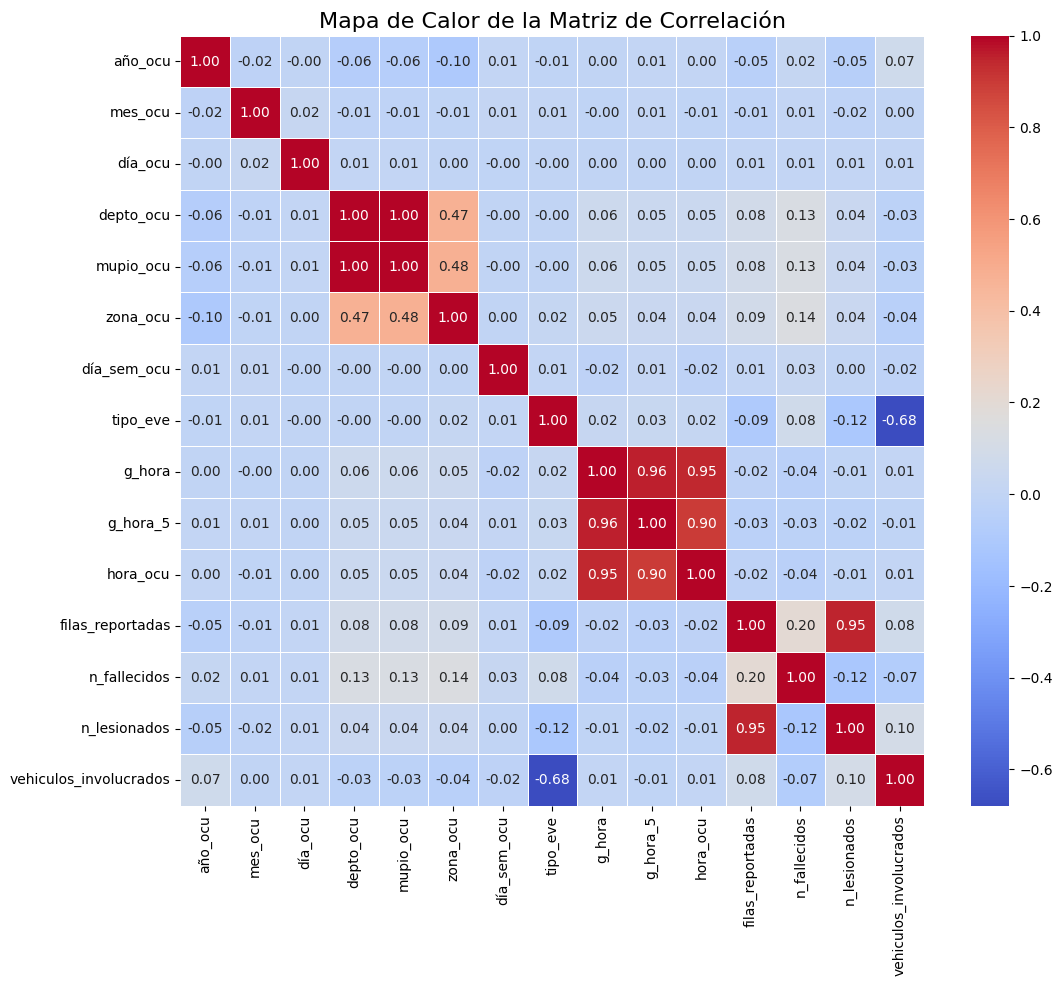

In [ ]:
plt.figure(figsize=(12, 10))

# Crear el heatmap
sns.heatmap(
    correlation_df_pandas,
    annot=True, 
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)

# Añadir un título
plt.title('Mapa de Calor de la Matriz de Correlación', fontsize=16)

# Mostrar la gráfica
plt.show()


Como se observa en el mapa de calor, la mayoría de variables no están relacionadas entre sí. Las que sí lo están, son usualmente las que indican datos similares, como zona, departamento y municipio, las que describen las horas, etc. Por el otro lado, la cantidad de fallecidos y lesionados está altamente correlacionada. Las variables vehículos involucrados y tipo de evento también muestran correlación moderada entre sí. 

## Reducción de dimensionalidad PCA

In [ ]:
# Ensamblar las columnas numéricas en un solo vector
assembler = VectorAssembler(inputCols=columnas_numericas, outputCol="features")
df_vectorized = assembler.transform(df_processed)

# Escalar las features para asegurar que todas las variables tengan la misma importancia
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)
scaler_model = scaler.fit(df_vectorized)
df_scaled = scaler_model.transform(df_vectorized)


pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca_result = pca_model.transform(df_scaled)



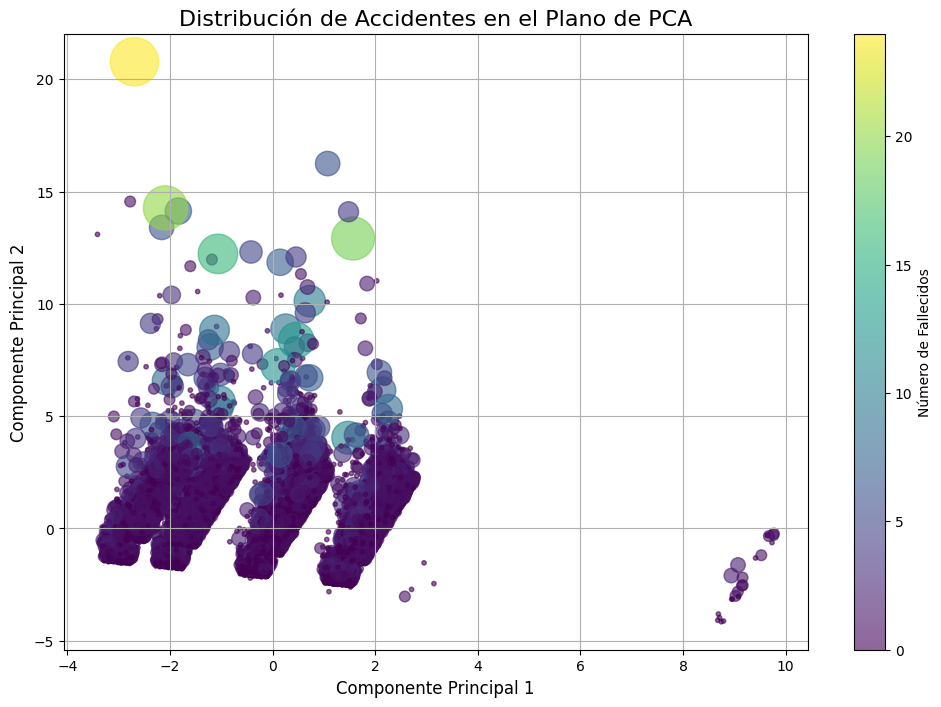

In [ ]:
# Convertir el resultado del PCA a un DataFrame de Pandas
df_pca_pandas = df_pca_result.select("pca_features").toPandas()

# Extraer los dos componentes principales en columnas separadas
df_pca_pandas['PC1'] = df_pca_pandas['pca_features'].apply(lambda x: x[0])
df_pca_pandas['PC2'] = df_pca_pandas['pca_features'].apply(lambda x: x[1])

df_display = df_pca_result.withColumn("n_fallecidos", F.col("n_fallecidos")).toPandas()
df_display['PC1'] = df_display['pca_features'].apply(lambda x: x[0])
df_display['PC2'] = df_display['pca_features'].apply(lambda x: x[1])

# Configurar el gráfico
plt.figure(figsize=(12, 8))

# Graficar la distribución de los accidentes en el plano PCA
plt.scatter(
    df_display['PC1'],
    df_display['PC2'],
    c=df_display['n_fallecidos'],
    cmap='viridis',
    alpha=0.6,
    s=df_display['n_fallecidos'] * 50 + 10 
)

# Añadir etiquetas y título
plt.title('Distribución de Accidentes en el Plano de PCA', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.colorbar(label='Número de Fallecidos') 

# Mostrar la gráfica
plt.grid(True)
plt.show()



## Segmentación KMeans

### Elección de k

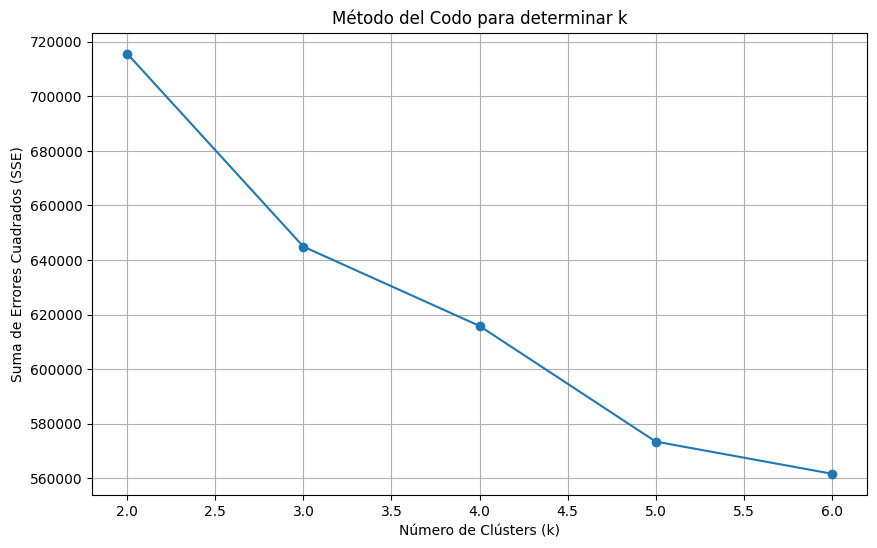

In [59]:
sse = []
k_values = range(2, 7)  

for k in k_values:
    kmeans = KMeans(featuresCol='scaledFeatures', k=k, seed=1)
    model = kmeans.fit(df_scaled)
    
    wssse = model.summary.trainingCost
    sse.append(wssse)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo para determinar k')
plt.xlabel('Número de Clústers (k)')
plt.ylabel('Suma de Errores Cuadrados (SSE)')
plt.grid(True)
plt.show()

Se puede observar que la gráfica de codo tiene un corte aproximado en **k = 3**. Aunque más adelante se pueden reducciones más significativas, aumentar el tamaño de clusters implica mucha complejidad y se pierde el objetivo de la segmentación. 

### Clusterización

In [60]:
optimal_k = 3
kmeans = KMeans(featuresCol='scaledFeatures', k=optimal_k, seed=1)
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled)

# Mostrar el conteo de accidentes por clúster
print("Conteo de accidentes por clúster:")
df_clustered.groupBy('prediction').count().orderBy('prediction').show()

# Caracterizar cada clúster
print("Estadísticas promedio por clúster:")
caracteristicas_clusters = df_clustered.groupBy('prediction').agg(
    {'hora_ocu': 'avg', 'n_fallecidos': 'avg', 'n_lesionados': 'avg', 'vehiculos_involucrados': 'avg'}
).orderBy('prediction')

caracteristicas_clusters = caracteristicas_clusters.withColumnRenamed('avg(hora_ocu)', 'avg_hora_ocu') \
                                                   .withColumnRenamed('avg(n_fallecidos)', 'avg_n_fallecidos') \
                                                   .withColumnRenamed('avg(n_lesionados)', 'avg_n_lesionados') \
                                                   .withColumnRenamed('avg(vehiculos_involucrados)', 'avg_vehiculos_involucrados')

caracteristicas_clusters.show()

Conteo de accidentes por clúster:
+----------+-----+
|prediction|count|
+----------+-----+
|         0|16562|
|         1|23705|
|         2|16049|
+----------+-----+

Estadísticas promedio por clúster:
+----------+------------------+--------------------------+-------------------+------------------+
|prediction|      avg_hora_ocu|avg_vehiculos_involucrados|   avg_n_fallecidos|  avg_n_lesionados|
+----------+------------------+--------------------------+-------------------+------------------+
|         0| 5.395060982973071|          1.49643762830576|0.28625769834561043|1.1309624441492574|
|         1|18.296140054840752|         1.514785910145539|0.20725585319552836| 1.137354988399072|
|         2|15.589631752757182|        1.4807153093650696| 0.3797744407751262|1.6205994142937254|
+----------+------------------+--------------------------+-------------------+------------------+



Se puede observar que los 3 clusters tienen cantidades bastante similares entre ellos. El que más accidentes tiene es el cluster 2, seguido por el 0 y 1 (el 0 y 1 son los que más se parecen en cantidad)

### Características

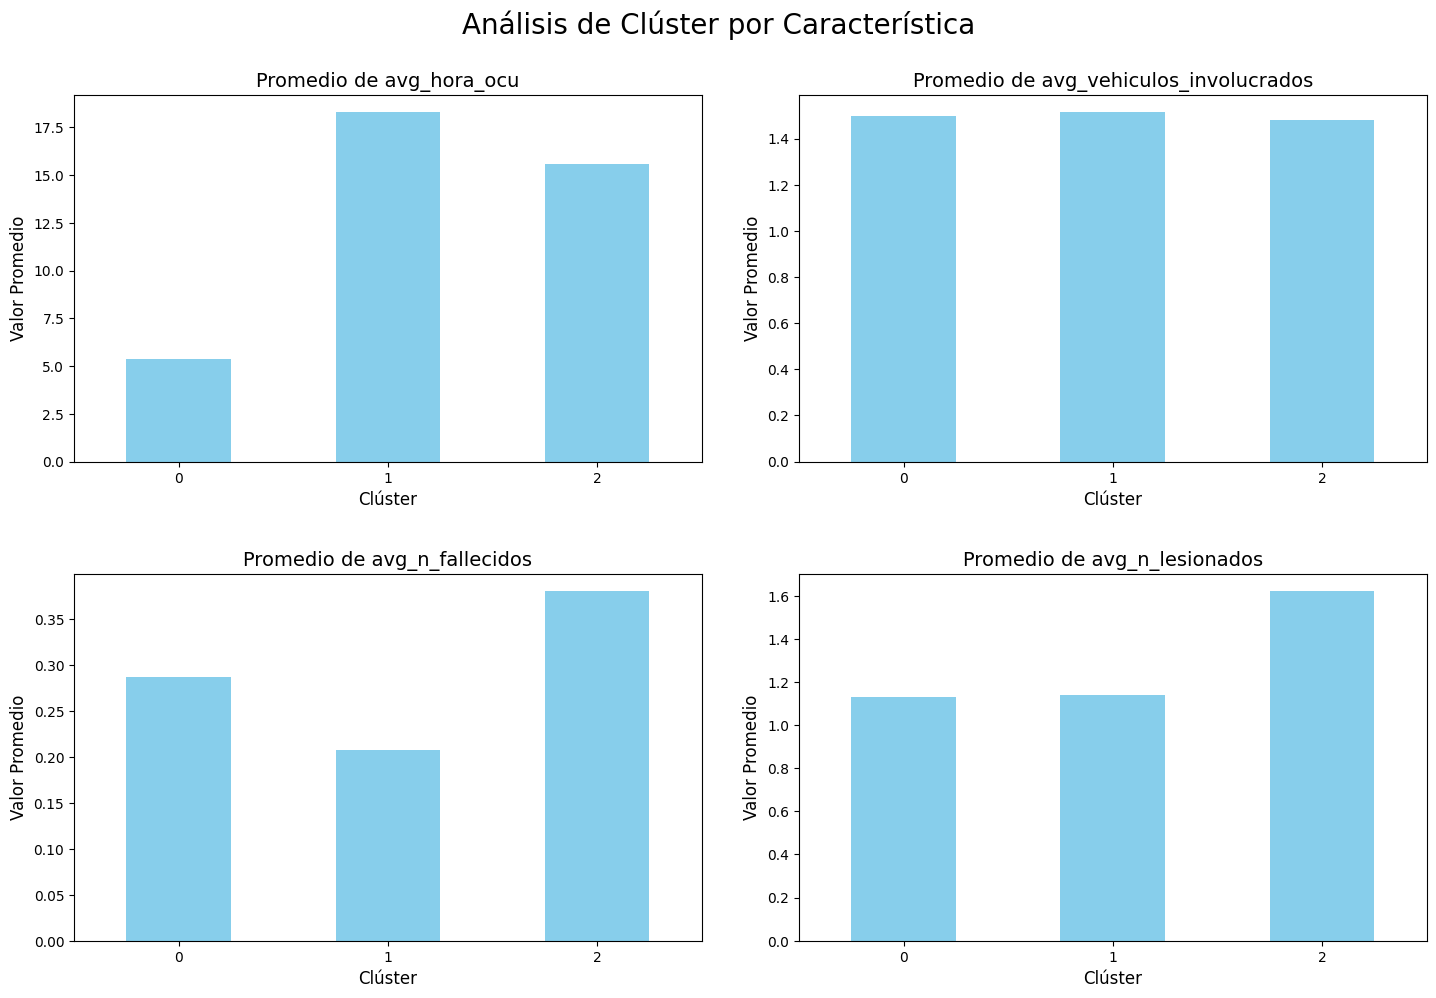

In [61]:
caracteristicas_clusters_pd = caracteristicas_clusters.toPandas()
caracteristicas_clusters_pd = caracteristicas_clusters_pd.set_index('prediction')
caracteristicas_clusters_melt = caracteristicas_clusters_pd.reset_index().melt('prediction')


caracteristicas = caracteristicas_clusters_pd.columns

n_caracteristicas = len(caracteristicas)
n_cols = 2
n_rows = (n_caracteristicas + n_cols - 1) // n_cols  # Calcular el número de filas de forma dinámica

# Crear la figura y los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, caracteristica in enumerate(caracteristicas):
    caracteristicas_clusters_pd[caracteristica].plot(
        kind='bar',
        ax=axes[i],
        color='skyblue'
    )
    axes[i].set_title(f'Promedio de {caracteristica}', fontsize=14)
    axes[i].set_xlabel('Clúster', fontsize=12)
    axes[i].set_ylabel('Valor Promedio', fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)

# Ocultar los subplots no utilizados si el número de características no es par
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar que los títulos se superpongan
plt.tight_layout(pad=3.0)

# Añadir un título principal a la figura
fig.suptitle('Análisis de Clúster por Característica', fontsize=20, y=1.02)
plt.show()

En los gráficos es posible observar las siguientes características:

- **Cluster 0:** La hora en la que ocurren estos accidentes es alrededor de las 5 de la mañana. El promedio de vehículos involucrados no cambia. El promedio de fallecidos y de lesionados es bastante más bajo que el del cluster 1. 

- **Cluster 1**: La hora en que ocurren los accidentes es alrededor de las 3pm. El promedio de vehículos involucrados es igual que en los demás clusters, lo que más cambia es la cantidad de lesionados total, que es más alta que la de los demás clusters. 

- **Cluster 2**: la hora de los accidentes es la más tarde, alrededor de las 6pm. La cantidad de vehículos involucrados es la misma que en los demás. La cantidad de fallecidos es la menor de los tres clusters y en cuanto a la cantidad de lesionados, se parece mucho al cluster 0. 

# Modelado supervisado para predicción

## Columna Severidad

In [62]:
df_final_con_severidad = df_final.withColumn(
    "severidad",
    F.when((F.col("n_fallecidos") > 1) | (F.col("n_lesionados") > 5), "Grave")
    .when((F.col("n_fallecidos") == 1) | ((F.col("n_lesionados") >= 2) & (F.col("n_lesionados") <= 5)), "Moderado")
    .otherwise("Leve")
)

df_final_con_severidad.show()


+-------+-------+-------+---------+---------+--------+-----------+--------+------+--------+--------+----------------+------------+------------+----------------------+---------+
|año_ocu|mes_ocu|día_ocu|depto_ocu|mupio_ocu|zona_ocu|día_sem_ocu|tipo_eve|g_hora|g_hora_5|hora_ocu|filas_reportadas|n_fallecidos|n_lesionados|vehiculos_involucrados|severidad|
+-------+-------+-------+---------+---------+--------+-----------+--------+------+--------+--------+----------------+------------+------------+----------------------+---------+
|   2015|      4|     10|        2|      203|      99|          5|       1|     4|       3|      21|               2|           2|           0|                     3|    Grave|
|   2015|      4|     27|        4|      401|      99|          1|       1|     4|       3|      21|               1|           0|           1|                     2|     Leve|
|   2015|      5|      1|        7|      705|      99|          5|       1|     2|       1|       9|               

## Train y Test

In [63]:
weights = [0.7, 0.3]
seed = 42

# Realizar la división
train_df, test_df = df_final_con_severidad.randomSplit(weights, seed=seed)

# Mostrar el conteo de registros en cada DataFrame para confirmar la proporción
print("Número de registros en el conjunto de entrenamiento:", train_df.count())
print("Número de registros en el conjunto de prueba:", test_df.count())


Número de registros en el conjunto de entrenamiento: 39649
Número de registros en el conjunto de prueba: 16688


## Pipeline de clasificación

In [64]:
# 1. Definir las variables 

# Variables categóricas a indexar 
categorical_features = ['tipo_eve', 'depto_ocu', 'día_sem_ocu', 'zona_ocu']

# Variables numéricas a ensamblar
numeric_features = [
    'hora_ocu', 'vehiculos_involucrados',
    'año_ocu', 'mes_ocu', 'día_ocu'
]

# Columna de etiqueta (severidad)
label_col = 'severidad'

# 2. Crear las etapas del Pipeline 

# a. StringIndexer para variables categóricas y la etiqueta
categorical_indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="skip") for c in categorical_features
]
label_indexer = StringIndexer(inputCol=label_col, outputCol="indexed_label")

# b. VectorAssembler para todas las variables
input_features = [f"{c}_indexed" for c in categorical_features] + numeric_features
assembler = VectorAssembler(inputCols=input_features, outputCol="raw_features")

# c. StandardScaler
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

# d. Modelo de RandomForestClassifier
rf = RandomForestClassifier(labelCol="indexed_label", featuresCol="features", seed=42)

#  3. Encadenar las etapas en un Pipeline 
pipeline = Pipeline(stages=categorical_indexers + [label_indexer, assembler, scaler, rf])

# 4. Entrenar el modelo 
model = pipeline.fit(train_df)

# 5. Realizar predicciones y evaluar el modelo 
predictions = model.transform(test_df)

# Mostrar algunas predicciones para verificar
predictions.select("severidad", "prediction", "indexed_label").show(5, truncate=False)

# Evaluar el modelo usando MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="f1")

# Calcular las métricas
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})


# Mostrar las métricas
print(f"F1-Score Ponderado: {f1_score:.4f}")
print(f"Precisión Ponderada: {precision:.4f}")
print(f"Recall Ponderado: {recall:.4f}")



+---------+----------+-------------+
|severidad|prediction|indexed_label|
+---------+----------+-------------+
|Leve     |1.0       |0.0          |
|Leve     |0.0       |0.0          |
|Moderado |0.0       |1.0          |
|Moderado |0.0       |1.0          |
|Leve     |0.0       |0.0          |
+---------+----------+-------------+
only showing top 5 rows

F1-Score Ponderado: 0.5539
Precisión Ponderada: 0.5609
Recall Ponderado: 0.5926


## Modelos adicionales

In [65]:

# Definir columnas categóricas
categorical_cols = [
    'depto_ocu', 'mupio_ocu', 'zona_ocu', 'día_sem_ocu',
    'tipo_eve'
]

# Ajustar los indexers una sola vez y transformar los datasets
categorical_indexers = []
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed", handleInvalid="keep")
    model = indexer.fit(train_df)
    train_df = model.transform(train_df)
    test_df = model.transform(test_df)
    categorical_indexers.append(model)

# Indexar la etiqueta (severidad)
label_indexer = StringIndexer(inputCol="severidad", outputCol="label", handleInvalid="keep")
label_model = label_indexer.fit(train_df)
train_df = label_model.transform(train_df)
test_df = label_model.transform(test_df)

# Armar la lista final de features
feature_cols = [f"{col}_indexed" for col in categorical_cols] + [
    'año_ocu', 'mes_ocu', 'día_ocu', 'hora_ocu',
    'filas_reportadas', 'vehiculos_involucrados'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Dataset preparado
train_df = assembler.transform(train_df)
train_df = scaler.fit(train_df).transform(train_df)
test_df = assembler.transform(test_df)
test_df = scaler.fit(test_df).transform(test_df)

In [66]:
# Evaluador
evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(metricName="weightedRecall")

# Lista para guardar resultados
resultados = []

# Función para entrenar y evaluar
def evaluar_modelo(nombre, modelo):
    modelo_fit = modelo.fit(train_df)
    pred = modelo_fit.transform(test_df)
    f1 = evaluator_f1.evaluate(pred)
    precision = evaluator_precision.evaluate(pred)
    recall = evaluator_recall.evaluate(pred)
    resultados.append((nombre, f1, precision, recall))

# --- Random Forest ---
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", seed=42)
evaluar_modelo("Random Forest", rf)

# --- Logistic Regression ---
lr = LogisticRegression(labelCol="label", featuresCol="scaled_features", maxIter=50)
evaluar_modelo("Logistic Regression", lr)

# --- Decision Tree ---
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")
evaluar_modelo("Decision Tree", dt)

# --- Tabla comparativa ---
resultados_df = spark.createDataFrame(resultados, ["Modelo", "F1", "Precisión", "Recall"])


In [67]:
resultados_df.show(truncate=False)

+-------------------+------------------+------------------+------------------+
|Modelo             |F1                |Precisión         |Recall            |
+-------------------+------------------+------------------+------------------+
|Random Forest      |0.7783446894376442|0.8260841304887054|0.7942833173537871|
|Logistic Regression|0.7816922608024524|0.8300639375067206|0.7967401725790988|
|Decision Tree      |0.7894496316702185|0.8101250884110349|0.7979985618408437|
+-------------------+------------------+------------------+------------------+



### Discusión

El modelo que muestra el mejor desempeño general es **Decision Tree**, ya que presenta el mayor **F1-score** (0.789) y mayor **recall** (0.798) entre los tres modelos evaluados. Aunque su **precisión** es ligeramente menor que la de Regresión Logística y Random Forest, su buen equilibrio entre precisión y recall lo hace el modelo más efectivo para nosotros en este caso. Esto puede deberse a que el conjunto de datos contiene relaciones no lineales o patrones que el árbol logra capturar de forma más directa. Por otro lado, el desempeño relativamente bajo del **Random Forest** podría deberse a una configuración no óptima de hiperparámetros o a que el problema no requiere tanta complejidad para ser modelado correctamente.

## Regresión lineal

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

dfLM = df_final.select("tipo_eve", "zona_ocu", "hora_ocu", "vehiculos_involucrados", "n_lesionados", "n_fallecidos")

indexers = [
    StringIndexer(inputCol="tipo_eve", outputCol="tipo_accidente_index"),
    StringIndexer(inputCol="zona_ocu", outputCol="zona_index"),
    StringIndexer(inputCol="hora_ocu", outputCol="hora_index")
]

assembler = VectorAssembler(
    inputCols=["tipo_accidente_index", "zona_index", "hora_index", "vehiculos_involucrados", "n_lesionados"],
    outputCol="features"
)

# Crear modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="n_fallecidos")

# Pipeline completo
pipeline = Pipeline(stages=indexers + [assembler, lr])

train_data, test_data = dfLM.randomSplit([0.8, 0.2], seed=42)

# Entrenar modelo
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

#Evaluar el modelo
evaluator_rmse = RegressionEvaluator(labelCol="n_fallecidos", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="n_fallecidos", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="n_fallecidos", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Guardar el modelo
model_output_path = "modelo_regresion_fallecidos.model"
if os.path.exists(model_output_path):
    import shutil
    shutil.rmtree(model_output_path)

model.write().overwrite().save(model_output_path)

El **RMSE** (0.543) y el **MAE** (0.393) reflejan un error promedio moderado en la predicción del número de fallecidos, también un **R²** de 0.053, lo que significa que el modelo solo explica alrededor del 5.3% de la variabilidad en los datos. Esto sugiere que las variables utilizadas (tipo de accidente, zona, hora, número de vehículos y lesionados) no son suficientes por sí solas para predecir con precisión el número de fallecidos, o que la relación entre estas variables y la variable objetivo no es lineal. 

## Recarga del modelo

In [ ]:
from pyspark.ml import PipelineModel

df_2023 = df_final.filter(df_final["año_ocu"] == 2023)
df_2023 = df_2023.select("tipo_eve", "zona_ocu", "hora_ocu", "vehiculos_involucrados", "n_lesionados", "n_fallecidos")

# Cargar el modelo guardado
modelo_path = "modelo_regresion_fallecidos.model"
modelo_cargado = PipelineModel.load(modelo_path)

predicciones_2023 = modelo_cargado.transform(df_2023)

# Resultados reales vs. predichos
predicciones_2023.select("n_fallecidos", "prediction").show(20, truncate=False)

## Análisis de la regresión

### Gráficas

In [ ]:
pred_df = predicciones_2023.select("n_fallecidos", "prediction").limit(1000).toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pred_df, x="n_fallecidos", y="prediction", alpha=0.6)

plt.plot([0, pred_df["n_fallecidos"].max()], [0, pred_df["n_fallecidos"].max()], color='red', linestyle='--', label='Predicción')

plt.xlabel("Fallecidos reales")
plt.ylabel("Fallecidos predichos")
plt.title("Predicción vs Real (Regresión lineal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Discusión

El modelo de regresión lineal tiende a subestimar los valores altos de fallecidos. En la gráfica se aprecia que la mayoría de las predicciones se agrupan cerca de valores bajos (entre 0 y 1), incluso cuando los valores reales llegan hasta 5. Además, los puntos con valores reales mayores (por ejemplo, 2 o más fallecidos) tienen predicciones consistentemente por debajo de la línea roja de predicción, lo que indica que el modelo no está capturando adecuadamente los casos más graves.El modelo se ajusta hacia el promedio, lo que resulta en una subestimación de los valores altos.